# Using Interval Variables and AddNoOverlap2D constraint for 2D rectangle packing

Given a rectangular container and a set of rectangular items, the goal is to pack all items into the container respecting the orientation of items.
All rectangles are orthogonal, i.e. they are parallel to the axes of the container.
Thus, each item is defined by its length and width.

This problem is also known as the 2D bin packing problem and is NP-hard.
With CP-SAT, we can easily model this problem and solve smaller instances to optimality.

In [1]:
from ortools.sat.python import cp_model
from ortools.sat.python.cp_model import Constraint

In [2]:
# Instance - Need to ensure all elements can fit in the bin, else the solution
# will be infeasible
container = (40, 15, 20)
boxes = [
    (11, 3, 4),
    (13, 3, 2),
    (9, 2, 4),
    (7, 2, 6),
    (9, 3, 1),
    (7, 3, 3),
    (11, 2, 3),
    (13, 2, 2),
    (11, 4, 7),
    (13, 4, 6),
    (3, 5, 1),
    (11, 2, 2),
    (2, 2, 3),
    (11, 3, 4),
    (2, 3, 5),
    (5, 4, 5),
    (6, 4, 4),
    (12, 2, 3),
    (1, 2, 2),
    (3, 5, 3),
    (13, 5, 1),
    (12, 4, 4),
    (1, 4, 1),
    (5, 2, 3),
    (6,  2, 1), # add to make tight
    #(6, 3, 1), # add to make infeasible
]

In [3]:
# New overlap definition - redefine cp_model

class MyCpModel(cp_model.CpModel):
    def MyAddNoOverlap2D(self, x_intervals, y_intervals, z_bool):
        """
        Adds NoOverlap2D(x_intervals, y_intervals).

        A NoOverlap2D constraint ensures that all present rectangles do not overlap
        on a plane. Each rectangle is aligned with the X and Y axis, and is defined
        by two intervals which represent its projection onto the X and Y axis.

        TODO: allow constraint to be enforced only if z_bool is True

        Args:
            x_intervals: The X coordinates of the rectangles.
            y_intervals: The Y coordinates of the rectangles.
            z_bool: boolean variable specifying if the constraints on the 
            corresponding ranges in x_intervals and y_intervals have to be 
            considered

        Returns:
        An instance of the `Constraint` class.
        """
        ct = Constraint(self)
        model_ct = self.__model.constraints[ct.Index()]
        model_ct.no_overlap_2d.x_intervals.extend(
            [self.GetIntervalIndex(x_intervals[i]) for i in range(len(x_intervals)) if z_bool[i]])
        model_ct.no_overlap_2d.y_intervals.extend(
            [self.GetIntervalIndex(y_intervals[i]) for i in range(len(y_intervals)) if z_bool[i]])
        return ct

In [4]:
# model = cp_model.CpModel()
model = MyCpModel()

In [5]:
# We have to create the variable for the bottom left corner of the boxes.
# We directly limit their range, such that the boxes are inside the container
x_vars = [
    model.NewIntVar(0, container[0] - box[0], name=f"x1_{i}")
    for i, box in enumerate(boxes)
]
y_vars = [
    model.NewIntVar(0, container[1] - box[1], name=f"y1_{i}")
    for i, box in enumerate(boxes)
]

# Interval variables are actually more like constraint containers, that are then
# passed to the no overlap constraint
# NOTE: we could also make size and end variables, but we don't need them here
x_interval_vars = [
    model.NewIntervalVar(
        start=x_vars[i], size=box[0], end=x_vars[i] + box[0], name=f"x_interval_{i}"
    )
    for i, box in enumerate(boxes)
]
y_interval_vars = [
    model.NewIntervalVar(
        start=y_vars[i], size=box[1], end=y_vars[i] + box[1], name=f"y_interval_{i}"
    )
    for i, box in enumerate(boxes)
]

y_interval_vars[0]

y_interval_0(start = y1_0, size = 3, end = y1_0 + 3)

In [6]:
# Weight constraint
z_vars = [model.NewBoolVar(f"z_{i}") for i in range(len(boxes))]
model.Add(sum(z_vars[i] * box[2] for i, box in enumerate(boxes)) <= container[2])

In [7]:
model.MyAddNoOverlap2D(x_interval_vars, y_interval_vars, z_vars)

AttributeError: 'MyCpModel' object has no attribute '_MyCpModel__model'

In [13]:
# Enforce that no two rectangles overlap, only if they are considered (weight 
# constraint)

for i in range(len(boxes)):
    model.AddNoOverlap2D(
        [x_interval_vars[i]], [y_interval_vars[i]],
    ).OnlyEnforceIf(z_vars[i])

In [113]:
for i, box in enumerate(boxes):
    model.Add(x_vars[i] == -2).OnlyEnforceIf(z_vars[i])
    model.Add(y_vars[i] == -2).OnlyEnforceIf(z_vars[i])


In [14]:
box_areas = [box[0]*box[1] for box in boxes]
model.Maximize(sum(z_vars[i] * box_areas[i] for i in range(len(boxes))))

In [16]:
# Solve!
solver = cp_model.CpSolver()
solver.parameters.log_search_progress = True
solver.log_callback = print
status = solver.Solve(model)
assert status == cp_model.OPTIMAL
w_boxes = []
for i, box in enumerate(boxes):
    if solver.Value(z_vars[i]) == 1:
        print(
            f"box {i} "
        )
        w_boxes.append(box)



Starting CP-SAT solver v9.6.2534
Starting CP-SAT solver v9.6.2534
Parameters: log_search_progress: true
Setting number of workers to 10
Parameters: log_search_progress: true
Setting number of workers to 10
Invalid model: Enforcement literal not supported in constraint: enforcement_literal: 176 no_overlap_2d { x_intervals: 204 y_intervals: 254 }
Invalid model: Enforcement literal not supported in constraint: enforcement_literal: 176 no_overlap_2d { x_intervals: 204 y_intervals: 254 }


CpSolverResponse summary:
status: MODEL_INVALID
objective: 0
best_bound: 0
integers: 0
booleans: 0
conflicts: 0
branches: 0
propagations: 0
integer_propagations: 0
restarts: 0
lp_iterations: 0
walltime: 0.000945
usertime: 0.000945
deterministic_time: 0
gap_integral: 0

CpSolverResponse summary:
status: MODEL_INVALID
objective: 0
best_bound: 0
integers: 0
booleans: 0
conflicts: 0
branches: 0
propagations: 0
integer_propagations: 0
restarts: 0
lp_iterations: 0
walltime: 0.000945
usertime: 0.000945
determi

AssertionError: 

In [125]:
for i in range(len(z_vars)):
    print(f"z_{i} = {solver.Value(z_vars[i])}")

z_0 = 0
z_1 = 1
z_2 = 0
z_3 = 0
z_4 = 1
z_5 = 0
z_6 = 0
z_7 = 1
z_8 = 0
z_9 = 1
z_10 = 1
z_11 = 1
z_12 = 0
z_13 = 0
z_14 = 0
z_15 = 0
z_16 = 0
z_17 = 0
z_18 = 0
z_19 = 0
z_20 = 1
z_21 = 1
z_22 = 0
z_23 = 0
z_24 = 1


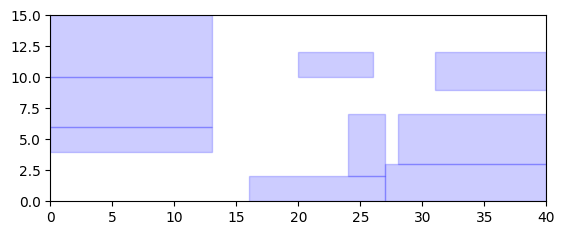

In [127]:
# plot the solution
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1)
ax.set_xlim(0, container[0])
ax.set_ylim(0, container[1])
for i, box in enumerate(boxes):
    if solver.Value(z_vars[i]) > 0:
        ax.add_patch(
            patches.Rectangle(
                (solver.Value(x_vars[i]), solver.Value(y_vars[i])),
                box[0],
                box[1],
                facecolor="blue",
                alpha=0.2,
                edgecolor="b",
            )
        )
# uniform axis
ax.set_aspect("equal", adjustable="box")
plt.show()